<a href="https://colab.research.google.com/github/Leviathan-31125/SiPetta-Bangkit-2023/blob/machine-learning/SiPetta%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Library
!pip install PySastrawi
import re
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

import string
string.punctuation
import csv

import numpy as np
import joblib
import pickle
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#Memanggil fungsi google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#Memasukkan dan membaca dataset
data = pd.read_csv('/content/dataset penyakit tanaman.csv')
data.head()

,no_penyakit,nama_penyakit,deskripsi_penyakit,NOTES
0,AP01,Busuk daun jamur,Daun bercak basah titik kecil berwarna gelap. ...,AP : Penyakit Andewi\nSP : Penyakit Selada\nWP...
1,AP02,Karat,muncul bercak karat. titik kecil berwarna oran...,NaN
2,SP01,Busuk daun,tulang daun terjadi bercak bersudut. berwarna ...,NaN
3,SP02,Busuk Rhizoctonia,"Tanaman mendekati masak, daun tua di atas tana...",NaN
4,SP03,Bercak daun,gejala tampak sebagai bercak kecil kebasahan p...,NaN


In [10]:
#menghapus kolom yang tidak diperlukan misal no penyakit dan notes
data = data.drop(["no_penyakit", 'NOTES'], axis=1)
data.head()

,nama_penyakit,deskripsi_penyakit
0,Busuk daun jamur,Daun bercak basah titik kecil berwarna gelap. ...
1,Karat,muncul bercak karat. titik kecil berwarna oran...
2,Busuk daun,tulang daun terjadi bercak bersudut. berwarna ...
3,Busuk Rhizoctonia,"Tanaman mendekati masak, daun tua di atas tana..."
4,Bercak daun,gejala tampak sebagai bercak kecil kebasahan p...


In [11]:
#melakukan preprocessing
import pandas as pd
class preprocessing:
    def __init__(self, data):   #membaca data
        self.data = pd.read_csv(data)

    def load_dataset(self):    #menampilkan data
        read = self.data['deskripsi_penyakit']
        return read

    def case_folding(self):   #mengubah data menjadi huruf kecil
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].str.lower()

    def remove_pattern(self, pattern_regex):    #menghapus karakter tertentu
      def remove_pattern(pattern_regex):
        r = re.findall(pattern_regex, self)
        for i in r:
            description = re.sub(i, ' ', self)
        return self
        self.data['deskripsi_penyakit'] = np.vectorize(remove_pattern)(self.data['deskripsi_penyakit'], " *RT* | *@[\w]* ")

    def remove_1(self, text):  #menghapus karakter tertentu
      def remove(text):
        text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lambda x: remove(x))

    def remove_2(self,text):
        def remove(text):
            #remove old style retweet text "RT"
            tweet = re.sub(r'^RT[\s]+', '', text)

            #remove old style retweet text "RT"
            tweet = re.sub(r'^RT[\s]+', '', text)

            #remove hastag
            #only removing the hash # sign from the word
            tweet = re.sub(r'#', '', text)

            #remove angka
            tweet = re.sub('[0-9]+', '', text)
            return tweet
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lambda x: remove(x))

    def tokenization(self,text):   #memisahkan teks menjadi per kata
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        def tokenize(text):
          text = re.split('\W+', text)
          return text
        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(tokenize)

    def stemming(self,text):   #menjadikan kata tokenize menjadi kata dasar
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()

        def stemmed_wrapper(term):
            return stemmer.stem(term)
        term_dict= {}

        for document in self.data['deskripsi_penyakit']:
            for term in document:
                if term not in term_dict:
                    term_dict[term] = ' '

        for term in term_dict:
            term_dict[term] = stemmed_wrapper(term)

        def get_stemmed_term(document):
            return [term_dict[term] for term in document]

        self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(get_stemmed_term)

    def lemmatizer(self, text):   #akar kata
      def lemma(text):
        wn = nltk.WordNetLemmatizer()
        text = [wn.lemmatize(word) for word in text]
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(lemma)

    def remove_punct(self, text):   #menghapus katakter
      def remove_punct(text):
        text = " ".join([char for char in text if char not in string.punctuation])
        return text
      self.data['deskripsi_penyakit'] = self.data['deskripsi_penyakit'].apply(remove_punct)

    def save(self):   #menyimpan data
        self.data.to_csv('/content/Dataset Penyakit Tanaman 2.csv', encoding = 'utf8', index = False)

In [13]:
# Memanggil class preprocessing dan menyimpannya
dataset = preprocessing(data='/content/dataset penyakit tanaman.csv')
cf = dataset.case_folding()
rp = dataset.remove_pattern(dataset)
r = dataset.remove_1(rp)
r2 = dataset.remove_2(r)
token = dataset.tokenization(r2)
st = dataset.stemming(token)
lz = dataset.lemmatizer(st)
rv = dataset.remove_punct(lz)
simpan = dataset.save()

In [14]:
#Membaca dataset dan menghapus kolom no penyakit dan notes
data = pd.read_csv('/content/Dataset Penyakit Tanaman 2.csv')
data = data.drop(["no_penyakit", 'NOTES'], axis=1)
data.head()

,nama_penyakit,deskripsi_penyakit
0,Busuk daun jamur,daun bercak basah titik kecil warna gelap daun...
1,Karat,muncul bercak karat titik kecil warna oranye a...
2,Busuk daun,tulang daun jadi bercak sudut warna hijau muda...
3,Busuk Rhizoctonia,tanam dekat masak daun tua di atas tanah infek...
4,Bercak daun,gejala tampak bagai bercak kecil basah pada te...


In [17]:
#Membuat fungsi untuk rekomendasi penyakit atau penyakit yang sesuai dengan deskripsi user
def penyakit_recommendations(nama_penyakit, similarity_data=cos_sim_data, items=data[['nama_penyakit', 'deskripsi_penyakit']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_penyakit].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movie agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_penyakit, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [21]:
from difflib import SequenceMatcher

# Fungsi untuk menghitung similarity menggunakan cosine similarity
def calculate_cosine_similarity(input_text, corpus):
    vectorizer = TfidfVectorizer()
    corpus.append(input_text)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    similarity_scores = similarity_matrix[-1, :-1]
    return similarity_scores

# Inputan pengguna
user_input = input("Masukkan teks yang ingin dibandingkan: ")

# Hitung similarity menggunakan cosine similarity
cosine_similarity_scores = calculate_cosine_similarity(user_input, data['deskripsi_penyakit'].str.lower().tolist())*100

# Tambahkan hasil similarity ke DataFrame
data['cosine_similarity'] = cosine_similarity_scores

# Temukan teks dengan cosine similarity paling besar
max_cosine_similarity_index = data['cosine_similarity'].idxmax()
max_cosine_similarity_penyakit = data.loc[max_cosine_similarity_index, 'nama_penyakit']
max_cosine_similarity_text = data.loc[max_cosine_similarity_index, 'deskripsi_penyakit']
max_cosine_similarity_value = data.loc[max_cosine_similarity_index, 'cosine_similarity']

#print("\nTeks dengan Cosine Similarity Paling Besar:")
print(f"Nama Penyakit: {max_cosine_similarity_penyakit}")
print(f"Text: {max_cosine_similarity_text}")
print(f"Cosine Similarity: {max_cosine_similarity_value}")

#model.save('cosine_similarity_model.h5')


Masukkan teks yang ingin dibandingkan: tanaman saya mengalami muncul bercak karat terdapat juga titik kecil berwarna coklat lalu bercak tersebut berkembang menjadi lesi besar terlihat seperti serbuk karat dan tanaman saya lainnya mulai tertular sehingga menghambat pertumbuhan dan mengurangi kualitas hasil panen tanaman saya
Nama Penyakit: Karat
Text: muncul bercak karat titik kecil warna oranye atau coklat bercak kembang jadi lesi besar lihat seperti serbuk karat sebar ke tanam lain lalu angin atau percik air alami turun sehat dan produktivitas hambat tumbuh tanam kurang kualitas hasil dan nilai ekonomi tanam
Cosine Similarity: 27.26765500418776


In [24]:
#Melihat hasil cosine similarity semua data dari hasil inputan user
data[['nama_penyakit', 'deskripsi_penyakit','cosine_similarity']]

,nama_penyakit,deskripsi_penyakit,cosine_similarity
0,Busuk daun jamur,daun bercak basah titik kecil warna gelap daun...,11.173269
1,Karat,muncul bercak karat titik kecil warna oranye a...,27.267655
2,Busuk daun,tulang daun jadi bercak sudut warna hijau muda...,5.599544
3,Busuk Rhizoctonia,tanam dekat masak daun tua di atas tanah infek...,3.133527
4,Bercak daun,gejala tampak bagai bercak kecil basah pada te...,9.241543
5,Busuk daun abu,busuk daun sebab oleh jamur atau bakteri daun ...,3.770589
6,Busuk daun Choanephora,tumbuh jamur choanephora cucurbitarium jamur k...,8.423334
7,Bercak daun stemphylium,gejala awal bagai bercak coklat atau abu abu b...,5.183569
8,Busuk bakteri,gejala awal busuk dan lunak pada jaring tanam ...,6.616572
9,Mosaik,muncul pola mosaik pola seperti berck warna te...,3.168464


## Deploy ke Aplikasi

In [20]:
#Import Library
import keras
import tensorflow as tf
import transformers

# Load the model
model_cos_sim = tf.keras.models.load_model('cosine_similarity_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_cos_sim)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('cosine_similarity_model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: ignored

## BERT


In [25]:
#import library
!pip install tokenization
import numpy as np
import pandas as pd
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [28]:
#memanggil dan membaca dataset
train_data = pd.read_csv('/content/dataset tingkat .csv')
test_data = pd.read_csv('/content/dataset gejala.csv')

In [29]:
test_data = test_data.drop(['nama_penyakit'], axis=1) #menghapus kolom nama penyakit
test_data = test_data.iloc[:, 0:5] #membaca data 1-5
test_data.head()

,tipe_gejala
0,Tanaman saya mengalami masalah busuk hitam. Bu...
1,Daun tanaman saya terinfeksi busuk basah. Saya...
2,Sawi saya terkena busuk hati atau jantung. Bag...
3,Tanaman saya menunjukkan gejala mosaik. Daunny...
4,Tanaman saya mengalami busuk bakteri. Bagian-b...


In [30]:
#melakukan encoder dan membuatnya sebagai kategorikal angka
label = preprocessing.LabelEncoder()
y = label.fit_transform(train_data['tingkat_keparahan'])
y = to_categorical(y)
print(y)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [31]:
#melihat label tingkat keparahan penyakit
labels = label.classes_
print(labels)

['Tingkat Parah' 'Tingkat Ringan' 'Tingkat Sedang']


In [32]:
#memanggil keras layer untuk bert
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=False)

In [33]:
from transformers import BertTokenizer

# Instantiate the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

def bert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
#membuat model dan layer pada bert
def build_model(bert_layer, max_len=100):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]

    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(3, activation='softmax')(lay)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [35]:
#mengencode tokenizer data train dan data testnya
max_len = 100
train_input = bert_encode(train_data.deskripsi_penyakit.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.tipe_gejala.values, tokenizer, max_len=max_len)
train_labels = y

In [36]:
#membuat model dan melihat hasil akhir atau summary modelnya
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 100)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 768),                1094822   ['input_word_ids[0][0]',  

In [37]:
#melakukan training pada data dengan menggunakan epoch 10 kali
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_bert_3_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = model.fit(
    train_input, train_labels,
    validation_split=0.3,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.1908 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to model_bert_3_1.h5
1/1 [==============================] - 26s 26s/step - loss: 1.1908 - accuracy: 0.3333 - val_loss: 1.1492 - val_accuracy: 0.2222
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.1407 - accuracy: 0.3333
Epoch 2: val_accuracy did not improve from 0.22222
1/1 [==============================] - 14s 14s/step - loss: 1.1407 - accuracy: 0.3333 - val_loss: 1.1976 - val_accuracy: 0.2222
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.1084 - accuracy: 0.3810
Epoch 3: val_accuracy did not improve from 0.22222
1/1 [==============================] - 10s 10s/step - loss: 1.1084 - accuracy: 0.3810 - val_loss: 1.2337 - val_accuracy: 0.2222
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.2381
Epoch 4: val_accuracy did not improve from 0.22222
1/1 [===

In [38]:
#melihat hasil loss dan akurasinya
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {final_loss:.4f}')
print(f'Final Training Accuracy: {final_accuracy:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')


Final Training Loss: 1.0350
Final Training Accuracy: 0.4762
Final Validation Loss: 1.1014
Final Validation Accuracy: 0.2222


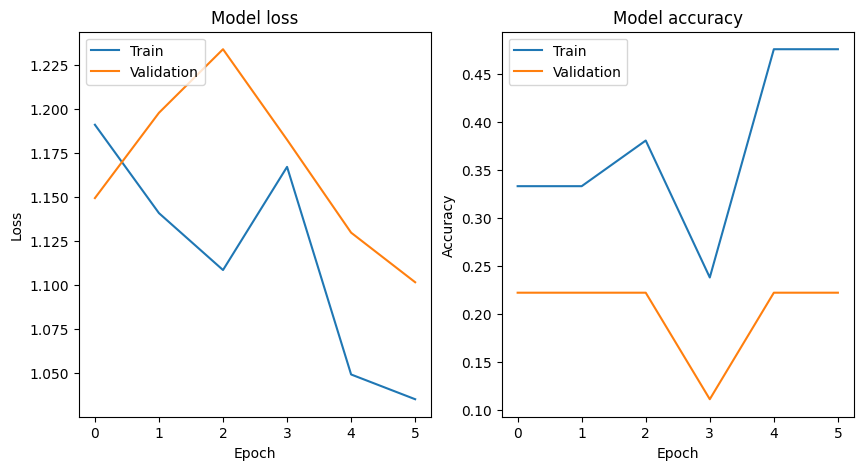

In [39]:
import matplotlib.pyplot as plt
# Plot training & validation loss values - model_trial1_new.h5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set(title='Model loss', xlabel='Epoch', ylabel='Loss')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
ax[1].set(title='Model accuracy', xlabel='Epoch', ylabel='Accuracy')
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['Train', 'Validation'], loc='upper left')

## Deploy ke Aplikasi

In [ ]:
import keras
import tensorflow as tf
import transformers

# Load the model
model_bert= tf.keras.models.load_model('model_bert_3_1.h5', custom_objects={'KerasLayer': bert_layer})

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_bert)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model_bert_3_1.tflite', 'wb') as f:
    f.write(tflite_model)
